<a href="https://colab.research.google.com/github/annisann/sentiment-analysis-for-conversational-texts/blob/dev/sentiment_analysist_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
**Script Structure**

**Project Structure** </br>
- root 
  - dataset 
    - raw
    - preprocessed
    - train
    - test
  - model 
    - tfidf
    - classifier
      - run_x
- src
  - notebook 
  - main 
    - core
    - utils


**utils**

In [3]:
# # work directory
# basePath = "/content/sentiment-analysis-for-conversational-texts/"
# datasetPath = basePath + "dataset/"
# rawPath = datasetPath + "raw/"
# processedPath = datasetPath + "processed/"
# trainPath = datasetPath + "train/"
# testPath = datasetPath + "test/"
# modelPath = basePath +"model/"
# tfidfPath = modelPath + "tfidf/"
# classifierPath = modelPath + "classifier/"

In [4]:
import os
# work directory
basePath = os.getcwd() + '/'
datasetPath = basePath + "dataset/"
rawPath = datasetPath + "raw/"
processedPath = datasetPath + "processed/"
trainPath = datasetPath + "train/"
testPath = datasetPath + "test/"
modelPath = basePath +"model/"
tfidfPath = modelPath + "tfidf/"
classifierPath = modelPath + "classifier/"

def isSpecialTerm(term):
    specialTerm = ["[DOSEN]", "[MHS]", "[URL]", "[EMAIL]", "<DOC>"]
    return term in specialTerm

**Preprocessing :**  </br>
casefolding -> stemming -> stopword removal 

In [5]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from deprecated import deprecated
import string 
import re
from nltk.corpus import stopwords
import nltk
import json

#global varible
nltk.download('stopwords')
factory = StemmerFactory()
stemmer = factory.create_stemmer()  
idStopWord = set(stopwords.words('indonesian'))
enStopWord = set(stopwords.words('english'))

def casefold(rawText):
    if isinstance(rawText , list):
        return [str(text).lower() for text in rawText]
    return str(rawText).lower()

def stem(rawText, toArray = False):
    if isinstance(rawText, list):
        rawText = " ".join(rawText)

    if toArray:
        return stemmer.stem(rawText).split(" ")

    return  stemmer.stem(rawText)

def clean(rawText):
   
    def _replaceURL(text):
        urlRegex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
        return re.sub(urlRegex, "[URL]", text)

    def _replaceEmail(text):
        urlRegex = r'([a-zA-Z0-9\.\_\-]+@+[a-zA-Z0-9.]+)'
        return re.sub(urlRegex, "[EMAIL]", text)
    
    def _removePunctuation(text):
        return re.sub(r'([!?.,;])\1+', '', str(text))

    def _normalizeWhitespace(text):
        corrected = str(text)
        corrected = re.sub(r"//t",r"\t", corrected)
        corrected = re.sub(r"( )\1+",r"\1", corrected)
        corrected = re.sub(r"(\n)\1+",r"\1", corrected)
        corrected = re.sub(r"(\r)\1+",r"\1", corrected)
        corrected = re.sub(r"(\t)\1+",r"\1", corrected)
        return corrected.strip(" ")

    @deprecated
    def _simplifyPunctuation(text):
        return re.sub(r'([!?,;])\1+', r'\1', str(text))
    
    if isinstance(rawText , list):
        rawText = " ".join(rawText)

    rawText = _replaceURL(rawText)
    rawText = _replaceEmail(rawText)
    rawText = _normalizeWhitespace(rawText)
    rawText = _removePunctuation(rawText)

    return rawText

def filter(rawText):
    if not isinstance(rawText, list):
        rawText = rawText.split(" ")
    return [w for w in rawText if not w in idStopWord and w not in enStopWord]

def normalize(rawText):
    with open(datasetPath+'slang_words.json', 'r') as f:
        dict = json.load(f)

    if  not isinstance(rawText , list):
        rawText = rawText.split(" ")
    token = []
    for word in rawText:
        slang_dict = {v:k for v, k in dict.items()}
        normal = slang_dict.get(word, word)
        token.append(normal)
    return token

def pipelinePreprocess(rawText):
    rawText = casefold(rawText)
    rawText = clean(rawText)
    rawText = stem(rawText)
    rawText = normalize(rawText)
    rawText = filter(rawText)
    return rawText

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Indexing Dataset**

In [6]:
import os
import json
import glob

files = (glob.glob(rawPath+"*.csv"))
indexToFile = {i:file for (i, file) in enumerate(files)}
fileToIndex = {file:i for (i, file) in enumerate(files)}

try:
    os.remove(processedPath+"indexToFile.json")
except:
    print()

with open(processedPath+"indexToFile.json", "w") as outfile: 
    json.dump(indexToFile, outfile)

try:
    os.remove(processedPath+"fileToIndex.json")
except:
    print()

with open(processedPath+"fileToIndex.json", "w") as outfile: 
    json.dump(fileToIndex, outfile)

**Preprocessing**

In [7]:
import glob
import pandas as pd
import numpy as np

In [8]:
def sessionManagement(file):
    df = pd.read_csv(file)
    df = df[df.timestamp.notnull()]
    sessions = df.timestamp.unique().tolist()
    sessionToIndex = {file:i for (i, file) in enumerate(sessions)}
    indexToSession = {i:file for (i, file) in enumerate(sessions)}

    try:
        os.remove(processedPath+str(fileToIndex[file])+"/indexToSession.json")
    except:
        pass

    with open(processedPath+str(fileToIndex[file])+"/indexToSession.json", "w") as outfile: 
        json.dump(indexToSession, outfile)

    try:
        os.remove(processedPath+str(fileToIndex[file])+"/sessionToIndex.json")
    except:
        pass

    with open(processedPath+str(fileToIndex[file])+"/sessionToIndex.json", "w") as outfile: 
        json.dump(sessionToIndex, outfile)

    df["session_index"] = [sessionToIndex[session] for session in df.timestamp]
    df["file_index"] = [fileToIndex[file] for session in df.timestamp]
    return df

In [9]:
def preprocess(df):
    messages = df.messages.tolist()
    preprocessed = []
    for message in messages:
        resp = pipelinePreprocess(message)
        preprocessed.append(resp)
    df["preprocessed"] = preprocessed
    return df

In [10]:
# preprocess every file
files = (glob.glob(rawPath+"*.csv"))
for file in files :
    raw = sessionManagement(file)
    preprocessed = preprocess(raw)
    preprocessed.to_csv(processedPath+str(fileToIndex[file])+'/'+str(fileToIndex[file])+'_preprocessed.csv')

In [16]:
# compile all preprocessed file

import fnmatch
import os
import pandas as pd 

matches = []
for root, dirnames, filenames in os.walk(processedPath):
    for filename in fnmatch.filter(filenames, '*.csv'):
        matches.append(os.path.join(root, filename))

counter = 1
for match in matches:
    printHeader = False
    if counter == 1:
        printHeader = True

    df = pd.read_csv(match)
    df.to_csv(processedPath+"compiled.csv", header=printHeader, mode="a", index=False)
    counter += 1

**build data train and test**

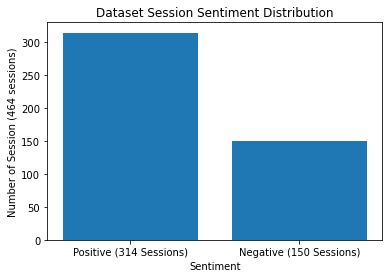

In [17]:
#check distribusi kelas
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv(processedPath+"compiled.csv")
df['unique_index'] =(df.session_index.astype(str) +"_"+ df.file_index.astype(str))
sessionDF = df.drop_duplicates(subset=['unique_index'], keep='last')
positiveSession = sessionDF[sessionDF.sentiment_per_sesi == 1]
negativeSession = sessionDF[sessionDF.sentiment_per_sesi == -1]


plt.bar(["Positive ("+str(len(positiveSession))+" Sessions)", "Negative ("+str(len(negativeSession))+" Sessions)"], [len(positiveSession), len(negativeSession)])
plt.title('Dataset Session Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Session ('+str(len(positiveSession) + len(negativeSession))+' sessions)')
plt.show()

In [18]:
import random 

trainPercentage = 80
testPercentage = 20

maximumNumberOfClass = min(len(positiveSession), len(negativeSession))

nTrain = int(trainPercentage /100 * maximumNumberOfClass)
nTest = int(testPercentage /100 * maximumNumberOfClass)

positiveID = positiveSession.unique_index.tolist()
negativeID = negativeSession.unique_index.tolist()
trainID = random.sample(positiveID, nTrain) + random.sample(negativeID, nTrain)

for id in trainID:
    try:
        positiveID.remove(id)
    except:
        negativeID.remove(id)

testID = random.sample(positiveID, nTest)
testID.append(random.sample(negativeID, nTest))

df[df.unique_index.isin(trainID)].to_csv(trainPath+"train.csv", index = False)
df[df.unique_index.isin(testID)].to_csv(testPath+"test.csv", index = False)

**Building Model Base**

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import string 
import ast
import pickle

def trainTFIDFModel(path=trainPath+"train.csv"):
    df = pd.read_csv(path)
    messages = [" ".join(ast.literal_eval(message)) for message in df.preprocessed]
    vectorizer = TfidfVectorizer(use_idf=True)
    X = vectorizer.fit(messages)

    with open(tfidfPath+"model.pickle", 'wb') as pickleFile:
        pickle.dump(vectorizer, pickleFile)

def loadTFIDFModel(path = tfidfPath+"model.pickle"):
    vectorizer = TfidfVectorizer()
    with open(path, 'rb') as pickleFile:
#         print(pickle.load(pickleFile))
        return pickle.load(pickleFile)
  
def TFIDF(terms, model):
    return model.transform(terms)

**Do TFIDF to Dataset**

In [20]:
# tfidfModel = trainTFIDFModel()
tfidfModel = loadTFIDFModel()
#  convert data train
df = pd.read_csv(trainPath+"train.csv")
messages = [" ".join(ast.literal_eval(message)) for message in df.preprocessed]
vectorized = TFIDF(messages, tfidfModel)
vectorized = pd.DataFrame(vectorized.todense())
vectorized['unique_index'] = df.unique_index
vectorized['sentiment_per_chat'] = df.sentiment_per_chat
vectorized['sentiment_per_sesi'] = df.sentiment_per_sesi
vectorized.to_csv(trainPath+"train_feed.csv")

df = pd.read_csv(testPath+"test.csv")
messages = [" ".join(ast.literal_eval(message)) for message in df.preprocessed]
vectorized = TFIDF(messages, tfidfModel)
vectorized = pd.DataFrame(vectorized.todense())
vectorized['unique_index'] = df.unique_index
vectorized['sentiment_per_chat'] = df.sentiment_per_chat
vectorized['sentiment_per_sesi'] = df.sentiment_per_sesi
vectorized.to_csv(testPath+"test_feed.csv")

**Base Classifier**

In [21]:
def transformInput(path = trainPath+"train_feed.csv"):
    target = []
    feature = []
    vectorized = pd.read_csv(path)

    uniqueID = vectorized.unique_index.unique().tolist()
    for unique in uniqueID:
        d = vectorized[vectorized.unique_index == unique]
        expected = [d.iloc[0].sentiment_per_sesi]
        if expected == [-1]:
            expected = [0] 
    target.append(expected)
    d = d.drop('unique_index',1)
    d = d.drop('sentiment_per_chat',1)
    d = d.drop('sentiment_per_sesi',1)
    d = d.drop(d.columns[0], axis=1)
    feature.append(d.to_numpy())
  
    return np.array(feature), np.array(target)

def dataGenerator(data, target, batch_size=1):
    counter = 0 
    samples_per_epoch = data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    while True:
        yield np.array([data[counter]]), target[counter]

        counter += 1
        if counter >= number_of_batches:
            counter = 0

In [22]:
import tensorflow as tf
import numpy as np 
import pickle
import os 
import glob
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import json 
from contextlib import redirect_stdout

def train(epochs = 10, batchSize = 1, verbose = 1, path = trainPath+"train_feed.csv"):
    dataTrain, groundTruth = transformInput(path)
    history  = model.fit_generator(dataGenerator(dataTrain, groundTruth, batchSize),  steps_per_epoch=dataTrain.shape[0]/batchSize, epochs=epochs, verbose=verbose)
    return history

def evaluate(batchSize = 10, path = testPath+"test_feed.csv"):
    dataTrain, groundTruth = transformInput(path)
    result = model.evaluate_generator(dataGenerator(dataTrain, groundTruth, batchSize),  steps=dataTrain.shape[0]/batchSize, verbose=0)
    return result

def predict(data):
    return model.predict(data)

def save(model, history, res):
    def getLastIndex():
        folder = [f for f in glob.iglob(classifierPath+"run_*")]
        return len(folder)
    processID = getLastIndex()+1
    workingDir = classifierPath+"run_"+str(processID)+"/"
    os.mkdir(workingDir)

    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    metadata = {
        "process_id":processID,
        "model_param":history.params,
        "train_result": history.history,
        "evaluation_result":{
            "metric_name":model.metrics_names,
            "value":res
        }
    }
    with open(workingDir+"summary.json", "w") as fw : 
        json.dump(metadata, fw, indent=4)

    with open(workingDir+"model_configuration.json", "w") as fw : 
        json.dump(model.get_config(), fw)

    with open(workingDir+'architecture.txt','w+') as f:
        with redirect_stdout(f):
            model.summary()
            
    model.save_weights(workingDir+"model_weight.h5")
    
    plot_model(model, to_file= workingDir+'model.png', show_shapes=True, show_layer_names=True)

def loadModel(processID):
    path = classifierPath+"run_"+str(processID)
    with open(path+"/model_configuration.json", 'r') as json_file:
        json_file = json.load(json_file)
    model = tf.keras.Sequential.from_config((json_file))
    model.load_weights(path + "/model_weight.h5")
    return model

D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

ImportError: cannot import name 'bincount_ops' from 'tensorflow.python.ops' (D:\Anaconda\lib\site-packages\tensorflow\python\ops\__init__.py)

**Tunning di marih**

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Input((None, 1262)),
  tf.keras.layers.LSTM(1262,activation='tanh', recurrent_activation='sigmoid',use_bias=True, return_sequences=True),
  tf.keras.layers.LSTM(1262,activation='tanh', recurrent_activation='sigmoid',use_bias=True),
  tf.keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
model.build((None, None,1262))

history = train(batchSize=10, epochs=10 , verbose=1)
resp = evaluate()
save(model, history, resp)

**Visualisasi History**

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

summaryPaths = [p for p in Path(classifierPath).rglob('summary.json')]

for summaryPath in summaryPaths:
    with open(summaryPath,"r") as f:
        summary = (json.load(f))
        print("===========================xxxxxxxxxxx===============================")
        print("process id: ",summary["process_id"])
        print("parameter : ",summary["model_param"])

        summaryPath = str(summaryPath).split("/")[:-1]
        summaryPath = "/".join(summaryPath)+"/architecture.txt"
        print(open(summaryPath, "r").read())

        print("evaluation loss" , summary["evaluation_result"]["value"][0])
        print("evaluation accuracy ",summary["evaluation_result"]["value"][1])
        print()
        plt.plot(summary["train_result"]["loss"])
        plt.plot(summary["train_result"]["accuracy"])
        plt.title('model training accuracy loss')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['loss', 'accuracy'], loc='upper left')
        plt.show()
        print()
        print()
        print()